# Transformer
自注意力与CNN和RNN相比具有并行计算和最短的最大路径长度这两个优势，所以使用自注意力来设计深度架构是很有吸引力的.

Transformer基于Encoder-Decoder架构来处理序列对，跟使用注意力的Seq2Seq不同，它是基于纯注意力的，没有RNN的参与。

## Component
1. 多头注意力
2. 有掩码的多头注意力
3. 基于位置的前馈网络
4. 层归一化 Layer Norm，Batch Norm对特征维度进行归一化，但是对于不定长数据来说不太行。
5. Message Passing


## Conclusion
- transformer 是一个纯使用注意力的编码-解码器
- 编码器和解码器都有n个transformer块
- 每个块里头使用多头自注意力，基于位置的前馈网络和层归一化函数。

![](../figures/Transformer.png)

In [1]:
import torch as t
import torch.nn as nn
from torch.nn.functional import relu
import math
import sys
sys.path.append("../")
from pltutils import *

In [2]:
# 定义基于位置的前馈网络
class PositionWiseFFN(nn.Module):
    def __init__(self,ffn_num_input,ffn_num_hiddens,ffn_num_outputs,**kwargs):
        super().__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input,ffn_num_hiddens)
        self.dense2 = nn.Linear(ffn_num_hiddens,ffn_num_outputs)
    
    def forward(self,X:t.Tensor):
        return self.dense2.forward(
            relu(
                self.dense1.forward(X)
            )
        )

# 测试一下
ffn = PositionWiseFFN(4,4,8)
ffn(t.ones((2,3,4))).shape
# 线性层会将最后一维除外的维度都看做batch

torch.Size([2, 3, 8])

In [3]:
# Normalization
ln=nn.LayerNorm(2)
bn=nn.BatchNorm1d(2)
X=t.tensor([[1,2,],[2,3]],dtype=t.float32)
ln(X),bn(X)

(tensor([[-1.0000,  1.0000],
         [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>),
 tensor([[-1.0000, -1.0000],
         [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>))

In [4]:
# 残差连接
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    def forward(self,X,Y):
        return self.ln(self.dropout(Y)+X)
        

In [5]:
# 现在我们有了组成编码器的基本组件，先来实现编码器中的一个层
class EncoderBlock(nn.Module):
    """
    transformer 编码器块
    """
    def __init__(self,key_size,query_size,value_size,num_hiddens,norm_shape,ffn_num_input,ffn_num_hiddens,num_heads,dropout,use_bias=False,**kwargs):
        super().__init__(**kwargs)
        self.attention = MultiHeadAttention(
            key_size,query_size,value_size,num_hiddens,num_heads,dropout,use_bias
        )
        self.addnorm1 = AddNorm(norm_shape,dropout,)
        self.ffn =PositionWiseFFN(ffn_num_input,ffn_num_hiddens,num_hiddens)
        self.addnorm2 = AddNorm(norm_shape,dropout,)
    
    def forward (self,X:t.Tensor,valid_lens:t.Tensor):
        Y =self.addnorm1(X,self.attention(X,X,X,valid_lens))
        return self.addnorm2(Y,self.ffn(Y))

In [6]:
# transformer编码器中的任何层都不会改变其输入的形状
X = t.ones((2,100,24))
valid_lens =t.tensor([3,2])
encoder_blk = EncoderBlock(
    24,24,24,24,[100,24],24,48,8,0.5
)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape


torch.Size([2, 100, 24])

In [7]:
# 现在实现num_layers个EncoderBlock的编码器
class TransformerEncoder(nn.Module):
    def __init__(self,vocab_size,key_size,query_size,value_size,num_hiddens,
    norm_shape,ffn_num_input,ffn_num_hiddens,num_heads,num_layers,dropout,
    use_bias=False,**kwargs):
        super().__init__(**kwargs)

        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size,num_hiddens)
        self.pos_endoding = PositionalEncoding(num_hiddens,dropout)

        self.blks = nn.Sequential()

        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
            EncoderBlock(
                key_size,query_size,value_size,num_hiddens,norm_shape,ffn_num_input,ffn_num_hiddens,num_heads,dropout,use_bias)
            )
        
    def forward(self,X:t.Tensor,valid_lens:t.Tensor,*args):
        X =self.pos_endoding(self.embedding.forward(X)*math.sqrt(self.num_hiddens))
        self.attention_weights = [None]*len(self.blks)

        for i ,blk in enumerate(self.blks):
            X =blk(X,valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [8]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

decoder会多一个valid_lens的变化。

In [14]:
# 解码器也是由多个相同的层组成，在DecoderBlock类中实现的每个层都包含了三个子层：解码器自注意力、
# 编码器-解码器注意力和基于位置的前馈网络
class DecoderBlock(nn.Module):
    """解码器中第i个块"""

    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state


In [16]:
class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 DecoderBlock(key_size, query_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights


尽管transformer架构是为了seq2seq的学习而提出的，但是transformer编码器或者是它的解码器通常被单独用于不同的学习任务中。


loss 0.031, 5892.0 tokens/sec on cuda:0


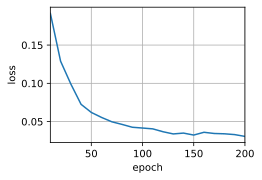

In [17]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')
